# Project Introduction

# Part 1. Data Processing
The following procedures demonstrate how the data for this project is collected, cleaned, and processed.

*   The data is downloaded from Kaggle.com, with the data seperated into 44 folders from the age range of 16 - 60.

*   The data is then sorted according to the purpose of our project.
For the age range 6- 60, the data is organized into the folder called "below_16", while for the age range 17-60, the data is organized into the folder named "under_16".

*   The data is then retrieved from these folders and splits into training, validation, and testing set.




In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import copy

use_cuda=True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Part (a) Sorting data and saving it to new folder

Firstly, the uncleaned images will be resized to 200x200 dimension, and the pixels will be normalized.

In [ ]:
uncleaned_data_path = "/content/gdrive/MyDrive/APS360 group project/uncleaned_data"

#Resize image, ensure all the same size for all images
transform = transforms.Compose([transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                ])

uncleaned_dataset = torchvision.datasets.ImageFolder(uncleaned_data_path,
                                                     transform = transform)

uncleaned_data_loader = torch.utils.data.DataLoader(uncleaned_dataset,
                                                    batch_size=1,
                                                    shuffle=True)
classes = ['008','009','010','011',
           '012','013','014','015',
           '016','017','018','019',
           '020','021','022','023',
           '024','025','026','027',
           '028','029','030','031',
           '032','033','034','035',
           '036','037','038','039',
           '040','041','042','043',
           '044','045','046','047',
           '048','049','050','051',
           '052','053','054','055',
           '056','057','058','059',
           '060']

folder = "/content/gdrive/MyDrive/APS360 group project/cleaned_dataset/"



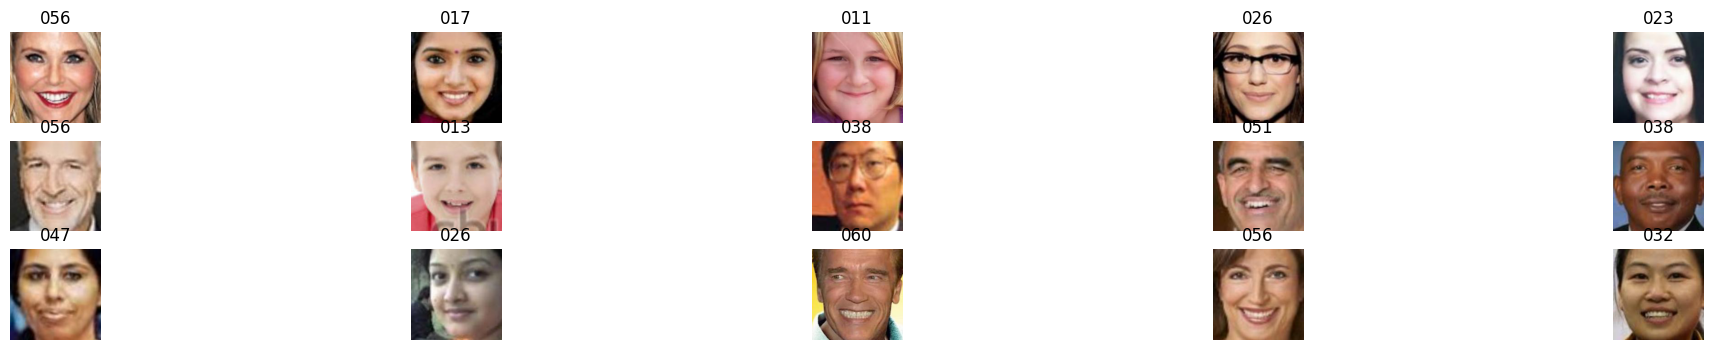

In [ ]:
#visualizing sample data
k = 0
classes = ['008','009','010','011',
           '012','013','014','015',
           '016','017','018','019',
           '020','021','022','023',
           '024','025','026','027',
           '028','029','030','031',
           '032','033','034','035',
           '036','037','038','039',
           '040','041','042','043',
           '044','045','046','047',
           '048','049','050','051',
           '052','053','054','055',
           '056','057','058','059',
           '060']

fig = plt.figure(figsize=(25, 4))

for images, labels in uncleaned_data_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    image = image.clip(0,1)
    label = labels[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img

    # Display the image
    ax = fig.add_subplot(3, 5, k+1)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(classes[label])  # Use label index to get the corresponding class

    k += 1
    if k >= 15:
        break

In [ ]:
for img, label in uncleaned_data_loader:
    print("Data type of img:", type(img))
    print("Data size of img:", img.size())
    print("Data type of label:", type(label))
    print("Data type of img tensor elements:", img.dtype)
    break

len(uncleaned_data_loader)

Next, the labeled data with age will be classify into 2 classes according to the threshold 16 years old. The processed data will be saved to two folders, "below_16" and "over_16".

To balance our data, we will limit the number of cases in each class. This means that number of image in each folder cannot exceed 1500.

In [ ]:
n = 1   # number of images with age below 16
m = 1    # number of images with age above 16

for img, label in uncleaned_data_loader:
  if(m>1500 and n>1500):
    break

  if (int(classes[label]) <= 16 and n <= 1500):
    torch.save(img.squeeze(), folder + 'below_16/'+ str(n) +
               '_' + str(classes[label]) +
               '_' + 'below_16' + '.tensor')
    n += 1

  elif(int(classes[label]) > 16 and m <= 1500):
    torch.save(img.squeeze(), folder + 'over_16/'+ str(m) +
               "_" + str(classes[label]) + '_' +
               'over_16'+ '.tensor')
    m += 1

### Part (b) Splitting data to training validation and testing

Then the data will be randomized and split into 3 sets: 75% into training set, 12.5% into validation set, and 12.5% into test set. The cleaned data will be split and stored into the folder caleed "cleaned_data".

In [ ]:
cleaned_dataset_path = "/content/gdrive/MyDrive/APS360 group project/cleaned_dataset"
cleaned_dataset = torchvision.datasets.DatasetFolder(cleaned_dataset_path,
                                                     loader=torch.load,
                                                     extensions=('.tensor'))

In [ ]:
train_size = int(0.75 * len(cleaned_dataset))
val_size = int(0.125 * len(cleaned_dataset))
test_size = len(cleaned_dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    cleaned_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
b_s = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=b_s,
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=b_s,
                                           num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=b_s,
                                           num_workers=1, shuffle=True)

In [ ]:
print('There are',len(train_loader)*b_s,
      'training images, which is {:.2f} % of the entire dataset.'.format(len(train_loader)*b_s/len(cleaned_dataset) * 100))
print('There are',len(val_loader)*b_s,
      'validation images, which is {:.2f} % of the entire dataset.'.format(len(val_loader)*b_s/len(cleaned_dataset) * 100))
print('There are',len(test_loader)*b_s,
      'test images, which is {:.2f} % of the entire dataset.'.format(len(test_loader)*b_s/len(cleaned_dataset) * 100))

There are 2078 training images, which is 74.99 % of the entire dataset.
There are 346 validation images, which is 12.49 % of the entire dataset.
There are 347 test images, which is 12.52 % of the entire dataset.


In [ ]:
for img, label in train_loader:
    print("Data type of img:", type(img))
    print("Data size of img:", img.size())
    print("Data type of label:", type(label))
    print("Data type of img tensor elements:", img.dtype)
    break

len(train_loader)

Data type of img: <class 'torch.Tensor'>
Data size of img: torch.Size([1, 3, 200, 200])
Data type of label: <class 'torch.Tensor'>
Data type of img tensor elements: torch.float32


2078

The following shows some of the sample data in our training set.

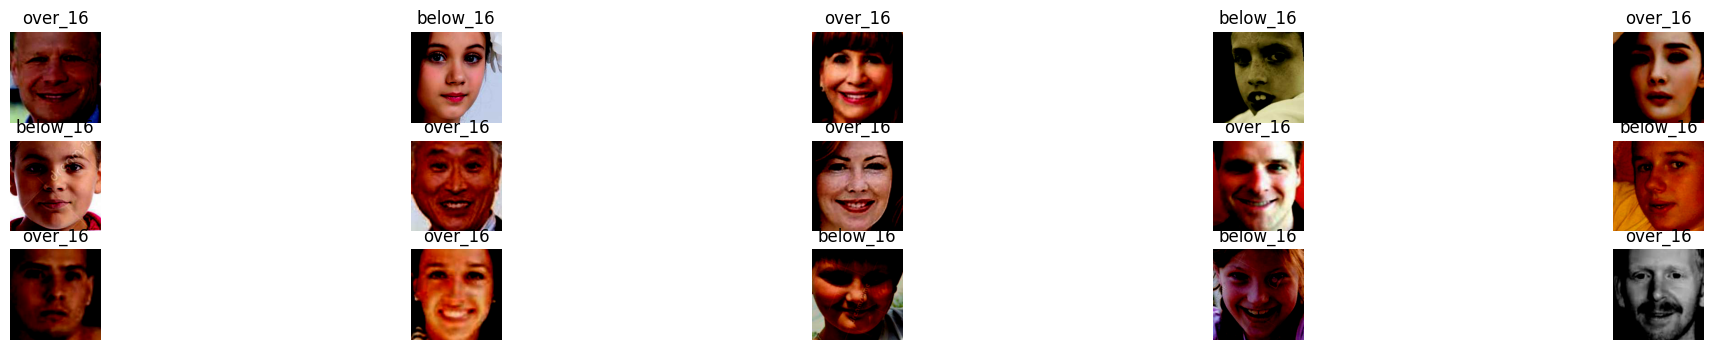

In [ ]:
#visualizing sample data
k = 0
classes = ['below_16', 'over_16']

fig = plt.figure(figsize=(25, 4))

for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    image = image.clip(0,1)
    label = labels[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img

    # Display the image
    ax = fig.add_subplot(3, 5, k+1)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(classes[label])  # Use label index to get the corresponding class

    k += 1
    if k >= 15:
        break

# Part 2. Baseline Model

See baseline model code through this link: https://colab.research.google.com/drive/17tAK23FxJ8eNkfQ45xZ8rGhbyREQsj7V?usp=sharing

# Part 3. Primary Model



*   We decide to apply transfer learning in our primary
*   VGG19 is chosen as feature extraction model for this project due to its specialization in facial recognition



### Part (a) Architecture (Transfer learning)

The model is built by a ANN classifer to process the feature extracted by VGG19. Firstly, we will install the model package (VGG19).

In [ ]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19 = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.1MB/s]


Next, CUDA will be enabled, and freezing parameters will be implemented to freeze the parameters of VGG19. Only paramters in the classifer will be trained and updated.

In [ ]:
#num_ftrs = model_ft.classifier[0].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

#model_ft = model_ft.to(device)

for param in vgg19.parameters():
    param.requires_grad = False

We extracte feature maps from training, validation, and test data sets and save them for later training.

In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)

classes = ['below_16', 'over_16']

# location on Google Drive
vgg19_path = '/content/gdrive/MyDrive/APS360 group project/vgg_features'

# define pre-set data
batch_size = 1
num_workers = 1

def get_vgg_feature(dataset, category):
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
  n = 0
  folder = vgg19_path + '/' + category + '/'

  # save features to folder as tensors
  # the print are for checking how much images are completed in the transformation
  for img, label in loader:
      features = vgg19.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())
      torch.save(features_tensor.squeeze(0),
                 folder + '/' + str(classes[label]) + '/' + str(classes[label]) + '_' + str(n) + '.tensor')
      n += 1

In [ ]:
get_vgg_feature(train_set, 'train')

In [ ]:
get_vgg_feature(val_set, 'val')

In [ ]:
get_vgg_feature(test_set, 'test')

We obtain and load VGG features through directories and use them in later training.

In [ ]:
vgg_train_folder = "/content/gdrive/MyDrive/APS360 group project/vgg_features/train"
vgg_val_folder = "/content/gdrive/MyDrive/APS360 group project/vgg_features/val"
vgg_test_folder = "/content/gdrive/MyDrive/APS360 group project/vgg_features/test"

In [ ]:
vgg_train_data = torchvision.datasets.DatasetFolder(vgg_train_folder, loader=torch.load, extensions=('.tensor'))
vgg_val_data = torchvision.datasets.DatasetFolder(vgg_val_folder, loader=torch.load, extensions=('.tensor'))
vgg_test_data = torchvision.datasets.DatasetFolder(vgg_test_folder, loader=torch.load, extensions=('.tensor'))

In [ ]:
b_size = 64
vgg_train_loader = torch.utils.data.DataLoader(vgg_train_data, batch_size=b_size, shuffle=True)
vgg_val_loader = torch.utils.data.DataLoader(vgg_val_data, batch_size=b_size, shuffle=True)
vgg_test_loader = torch.utils.data.DataLoader(vgg_test_data, batch_size=b_size, shuffle=True)

We build a two-layer ANN classifier to classify extracted feature maps

In [ ]:
class VGG_Classifier(nn.Module):
    def __init__(self):
        super(VGG_Classifier, self).__init__()
        self.name="VGGCS"
        self.fc1 = nn.Linear(512*6*6, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = x.view(-1, 512*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Optimizer, loss function, and scheduler are defined for tuning paramters

In [ ]:
trans_classifier2 = VGG_Classifier()
#trans_classifier = trans_classifier.to(device)
# Observe that all parameters are being optimized
optimizer = optim.SGD(trans_classifier2.parameters(), lr=0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.2)

### Part (b) Training Functions

In [ ]:
def plot(iters, train_losses, val_losses, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# @title
def train_transfer_learning(model, criterion, optimizer, scheduler, num_epochs=25):

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []
    best_acc = 0.0


    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data = vgg_train_loader
                data_size = train_size
            else:
                model.eval()
                data = vgg_val_loader   # Set model to evaluate mode
                data_size = val_size
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in data:
                #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    real_pred = model(inputs)
                    _, preds = torch.max(real_pred, 1)
                    loss = criterion(real_pred, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / data_size
            epoch_acc = running_corrects.double() / data_size
            #epoch_acc = epoch_acc.cpu()

            if phase == 'train':
              train_acc.append(epoch_acc)
              train_losses.append(epoch_loss)
            if phase == 'val':
              val_acc.append(epoch_acc)
              val_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            model_path = '{} {}'.format(phase,epoch)
            torch.save(model.state_dict(), model_path)
            # deep copy the model
        print("")
        iters.append(epoch)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    plot(iters, train_losses, val_losses, train_acc, val_acc)

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))




In [ ]:
# @title
def get_trans_test_accuracy(model, t_loader):

    data = t_loader

    correct = 0
    total = 0

    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

### Part (c) Training

Epoch 0/10
----------
train Loss: 0.4961 Acc: 0.7565
val Loss: 0.4748 Acc: 0.7717

Epoch 1/10
----------
train Loss: 0.3579 Acc: 0.8378
val Loss: 0.4286 Acc: 0.8035

Epoch 2/10
----------
train Loss: 0.2955 Acc: 0.8657
val Loss: 0.3531 Acc: 0.8382

Epoch 3/10
----------
train Loss: 0.2697 Acc: 0.8797
val Loss: 0.3505 Acc: 0.8439

Epoch 4/10
----------
train Loss: 0.2570 Acc: 0.8917
val Loss: 0.3545 Acc: 0.8497

Epoch 5/10
----------
train Loss: 0.1892 Acc: 0.9269
val Loss: 0.3826 Acc: 0.8555

Epoch 6/10
----------
train Loss: 0.1291 Acc: 0.9514
val Loss: 0.5124 Acc: 0.8208

Epoch 7/10
----------
train Loss: 0.1004 Acc: 0.9687
val Loss: 0.4008 Acc: 0.8757

Epoch 8/10
----------
train Loss: 0.0610 Acc: 0.9870
val Loss: 0.4031 Acc: 0.8786

Epoch 9/10
----------
train Loss: 0.0472 Acc: 0.9899
val Loss: 0.4226 Acc: 0.8873

Epoch 10/10
----------
train Loss: 0.0404 Acc: 0.9923
val Loss: 0.4214 Acc: 0.8786

Training complete in 4m 60s


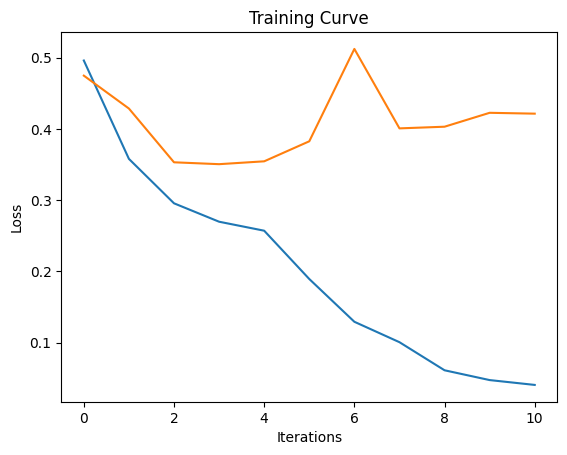

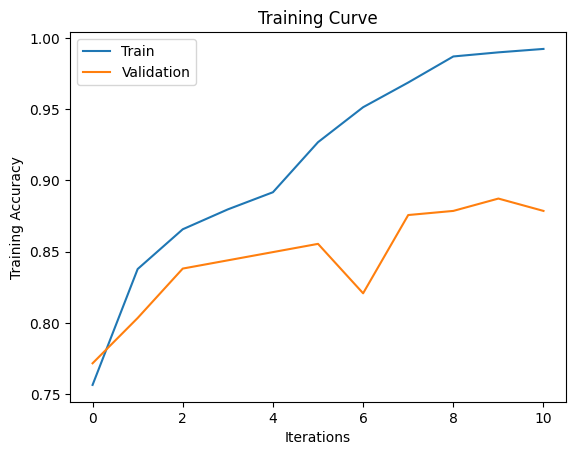

Final Training Accuracy: 0.9923002887391723
Final Validation Accuracy: 0.8786127167630058


In [ ]:
train_transfer_learning(trans_classifier2, criterion, optimizer, exp_lr_scheduler, num_epochs = 11)

### Part (d) Test Accuracy and Evaluate Model on New data

We obtained a test accuracy of the model on the test data set

In [ ]:
get_trans_test_accuracy(trans_classifier2, vgg_test_loader)

0.8530259365994236

We also collected our own data for testing the model's performance on unseen data

In [ ]:
new_test_data_path = "/content/gdrive/MyDrive/APS360 group project/new_test_data"

#Resize image, ensure all the same size for all images
transform = transforms.Compose([transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                ])

new_test_dataset = torchvision.datasets.ImageFolder(new_test_data_path,
                                                     transform = transform)

new_test_data_loader = torch.utils.data.DataLoader(new_test_dataset,
                                                    batch_size = 1,
                                                    shuffle=True)

In [ ]:
updated_data_path = "/content/gdrive/MyDrive/APS360 group project/newnew_test_data"

#Resize image, ensure all the same size for all images
transform = transforms.Compose([transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                ])

updated_dataset = torchvision.datasets.ImageFolder(updated_data_path,
                                                     transform = transform)

updated_data_loader = torch.utils.data.DataLoader(updated_dataset,
                                                    batch_size = 1,
                                                    shuffle=True)

We will save the VGG feature of our own data for the model to predict

In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)

classes = ['below_16', 'over_16']

# location on Google Drive
own_vgg_path = '/content/gdrive/MyDrive/APS360 group project/own_vgg_feature'

# define pre-set data
batch_size = 1
num_workers = 1

def get_own_vgg(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
  n = 0
  folder = own_vgg_path + '/'

  # save features to folder as tensors
  # the print are for checking how much images are completed in the transformation
  for img, label in loader:
      features = vgg19.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())
      torch.save(features_tensor.squeeze(0),
                 folder + str(classes[label]) + '/' + str(classes[label]) + '_' + str(n) + '.tensor')
      n += 1

In [ ]:
get_own_vgg(new_test_dataset)

We then load our own VGG features to data loader

In [ ]:
own_vgg_folder = "/content/gdrive/MyDrive/APS360 group project/own_vgg_feature"
own_vgg_data = torchvision.datasets.DatasetFolder(own_vgg_folder, loader=torch.load, extensions=('.tensor'))
own_vgg_loader = torch.utils.data.DataLoader(own_vgg_data, batch_size=b_size, shuffle=True)

In [ ]:
get_trans_test_accuracy(trans_classifier2, own_vgg_loader)

0.5576923076923077

In [ ]:
def get_updated_accuracy(model, t_loader):

    data = t_loader

    correct = 0
    total = 0

    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################
        imgs = vgg19.features(imgs)
        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

This is the final test accuracy of our model on self-collected data

In [ ]:
get_updated_accuracy(trans_classifier2, updated_data_loader)

0.7346938775510204

### Part (e) Displaying Sample Prediction

We first display some sample predictions on the self-collected data set

In [ ]:
cd /content/gdrive/MyDrive/APS360 group project/four_data

/content/gdrive/.shortcut-targets-by-id/1lqGt5-2nBKNxRlWLUyz1KBbGfBrvOBi5/APS360 group project/four_data


In [ ]:
from PIL import Image

In [ ]:
def show_prediction(name):
  name_img = Image.open(name+'.jpg')
  plt.imshow(name_img)
  plt.show()
  transform = transforms.Compose([
      transforms.Resize((200, 200)),
      transforms.ToTensor(),
      transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
  name_tensor = transform(name_img)
  name_feature = vgg19.features(name_tensor)
  prediction = trans_classifier2(name_feature)
  prob = F.softmax(prediction, dim = 1)
  print("The probability of", name, "to be classfied as below 16 is: {:f} %.".format(float(prob[0,0]*100)))
  print("The probability of", name, "to be classfied as over 16 is: {:f} %.".format(float(prob[0,1]*100)))

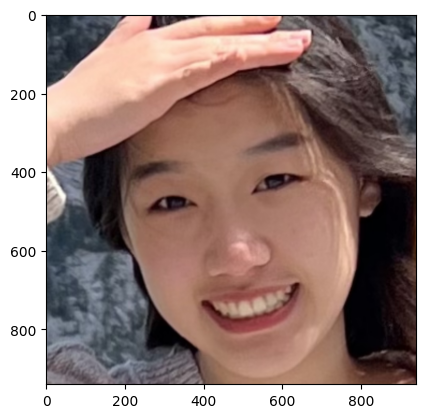

The probability of Alissa to be classfied as below 16 is: 99.957047 %.
The probability of Alissa to be classfied as over 16 is: 0.042956 %.


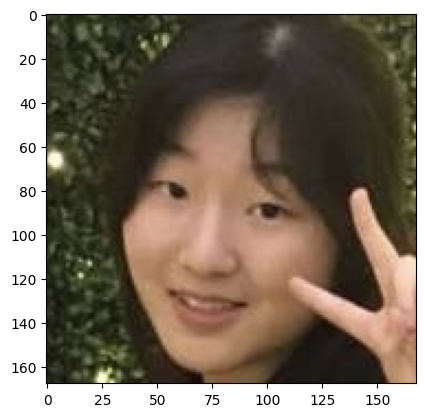

The probability of Rachel to be classfied as below 16 is: 84.467903 %.
The probability of Rachel to be classfied as over 16 is: 15.532096 %.


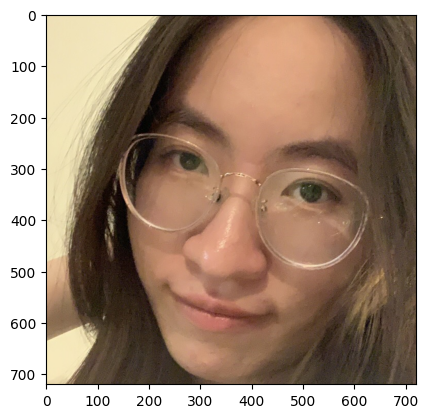

The probability of Olivia to be classfied as below 16 is: 99.972206 %.
The probability of Olivia to be classfied as over 16 is: 0.027796 %.


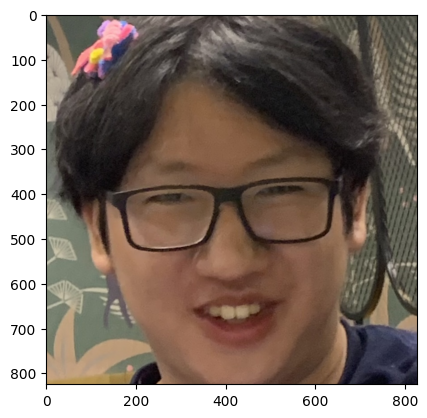

The probability of Jerry to be classfied as below 16 is: 69.334290 %.
The probability of Jerry to be classfied as over 16 is: 30.665705 %.


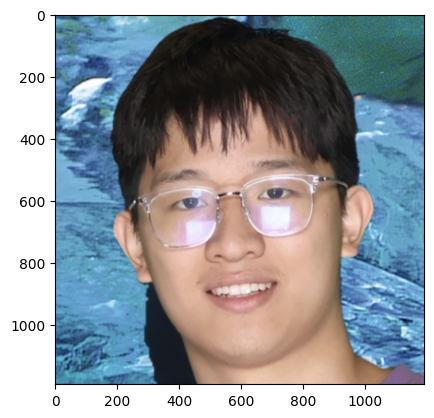

The probability of William to be classfied as below 16 is: 99.991287 %.
The probability of William to be classfied as over 16 is: 0.008710 %.


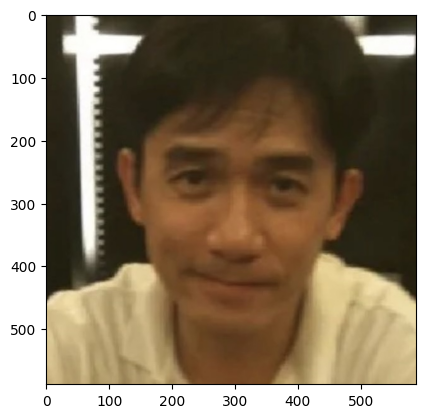

The probability of Liang to be classfied as below 16 is: 9.146045 %.
The probability of Liang to be classfied as over 16 is: 90.853951 %.


In [ ]:
show_prediction('Alissa')
show_prediction('Rachel')
show_prediction('Olivia')
show_prediction('Jerry')
show_prediction('William')
show_prediction('Liang')

We display sample prediction of the model on the original test set

In [ ]:
cd /content/gdrive/MyDrive/APS360 group project/kaggle_data_pred

/content/gdrive/.shortcut-targets-by-id/1lqGt5-2nBKNxRlWLUyz1KBbGfBrvOBi5/APS360 group project/kaggle_data_pred


In [ ]:
def show_age_prediction(age):
  name_img = Image.open(age+'.png')
  plt.imshow(name_img)
  plt.show()
  transform = transforms.Compose([
      transforms.Resize((200, 200)),
      transforms.ToTensor(),
      transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
  name_tensor = transform(name_img)
  name_feature = vgg19.features(name_tensor)
  prediction = trans_classifier2(name_feature)
  prob = F.softmax(prediction, dim = 1)
  print("This person is", age, "years old.")
  print("The probability of this person to be classfied as below 16 is: {:f} %.".format(float(prob[0,0]*100)))
  print("The probability of this person to be classfied as over 16 is: {:f} %.".format(float(prob[0,1]*100)))

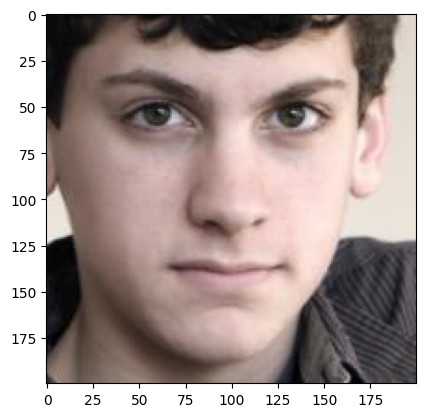

This person is 16 years old.
The probability of this person to be classfied as below 16 is: 98.790710 %.
The probability of this person to be classfied as over 16 is: 1.209284 %.


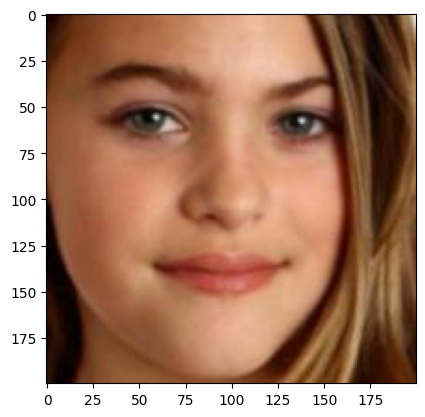

This person is 13 years old.
The probability of this person to be classfied as below 16 is: 90.641228 %.
The probability of this person to be classfied as over 16 is: 9.358772 %.


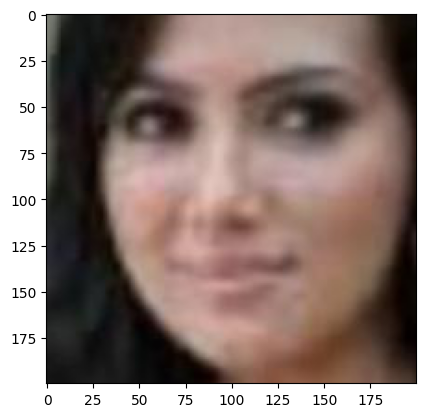

This person is 34 years old.
The probability of this person to be classfied as below 16 is: 1.043613 %.
The probability of this person to be classfied as over 16 is: 98.956390 %.


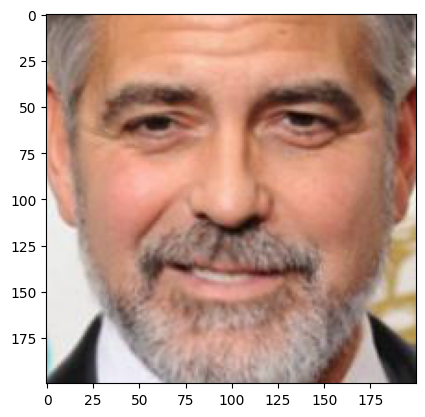

This person is 54 years old.
The probability of this person to be classfied as below 16 is: 0.000124 %.
The probability of this person to be classfied as over 16 is: 99.999878 %.


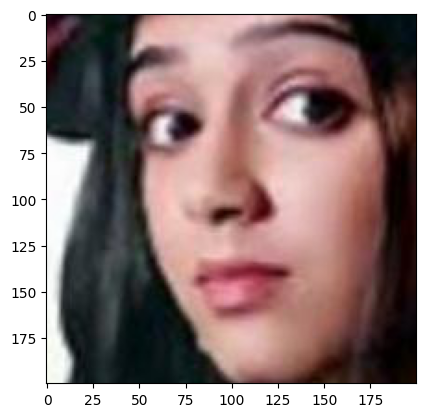

This person is 19 years old.
The probability of this person to be classfied as below 16 is: 0.663882 %.
The probability of this person to be classfied as over 16 is: 99.336113 %.


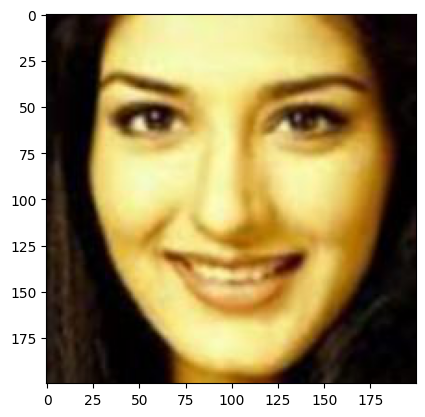

This person is 22 years old.
The probability of this person to be classfied as below 16 is: 0.007917 %.
The probability of this person to be classfied as over 16 is: 99.992081 %.


In [ ]:
show_age_prediction('16')
show_age_prediction('13')
show_age_prediction('34')
show_age_prediction('54')
show_age_prediction('19')
show_age_prediction('22')

### Part (f) Accuracy on Each Class

We are able to find the accuracy of the model on each class so that we obatin a better understanding of the model's performance

In [ ]:
classes = ['below_16', 'over_16']

def get_class_accuracy(model, t_set, group):

    bs = 1
    loader = torch.utils.data.DataLoader(t_set,
                                         batch_size=bs,
                                         num_workers=1,
                                         shuffle=True)

    correct = 0
    total = 0

    for img, label in loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        if(str(classes[label]) == group):
          output = model(img)

          #select index with maximum prediction score
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(label.view_as(pred)).sum().item()
          total += img.shape[0]

    return correct / total

These are the class-wise accuracy on the original test data

In [ ]:
get_class_accuracy(trans_classifier2,
                   vgg_test_data,
                   'below_16')

0.8245614035087719

In [ ]:
get_class_accuracy(trans_classifier2,
                   vgg_test_data,
                   'over_16')

0.8806818181818182

These are the class-wise accuracy on the self-collected data set

In [ ]:
classes = ['below_16', 'over_16']

def get_updated_class_accuracy(model, t_loader, group):

    loader = t_loader
    correct = 0
    total = 0

    for img, label in loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        if(str(classes[label]) == group):
          img = vgg19.features(img)
          output = model(img)

          #select index with maximum prediction score
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(label.view_as(pred)).sum().item()
          total += img.shape[0]

    return correct / total

In [ ]:
get_updated_class_accuracy(trans_classifier2,
                           updated_data_loader,
                           'below_16')

0.8367346938775511

In [ ]:
get_updated_class_accuracy(trans_classifier2,
                           updated_data_loader,
                           'over_16')

0.6326530612244898